In [1]:
# use seastar Kernel on adrien local nov laptop

import os
import xarray as xr
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
#import cartopy.crs as ccrs # => to add in Seastar env
import seastar
from seastar.utils.tools import dotdict, lin2db
from seastar.performance import scene_generation

from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares
from scipy.stats import circmean, circstd

# from seastar.gmfs.doppler import *

In [2]:
SciReC_simu = os.path.join('..','..','..','SEASTAR','SciRec')

In [3]:
colorlinewidth = .5

# Analysis

In [4]:
config = []
config.append({'nickname': '3base', 'nickname2': '3base_RSVnan',
               'version': 'v20230609',
               'size': '011x100',
              'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan',
             'ls': '-',  'color': 'k'})
config.append({'nickname': '3base_RSV40', 'nickname2': '3base_RSV40',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40',
             'ls': '-',  'color': 'C2'})
config.append({'nickname': '2base', 'nickname2': '2base',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '2base_2AC15_35_011x100_SNKp03RSV07',
             'ls': ':',  'color': 'k'})
config.append({'nickname': '4base_RSVnan', 'nickname2': '4base_RSVnan',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan_MHNKp04RSVnan',
             'ls': '--',  'color': 'k'})
config.append({'nickname': '4base_RSV40', 'nickname2': '4base_RSV40',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40_MHNKp04RSV40',
              'ls': '--',  'color': 'C2'})
# config.append({'nickname': '3sq29', # not the same grid in across <= issues in concat
#                'version': 'v20230825',
#                'size': '011x100',
#               'instname': '3sq29_3AC19_39_011x100_SNKp03RSV07_MVNKp04RSVnan'})

In [26]:
config_3sq29 = []
config_3sq29.append({'nickname': '3sq29', 'nickname2': '3sq29_RSVnan',
               'version': 'v20230825',
               'size': '011x100',
              'instname': '3sq29_3AC19_39_011x100_SNKp03RSV07_MVNKp04RSVnan',
                'ls': '-',  'color': 'C0'})

# Analysis for all config except the 3 squint 29

In [6]:
config

[{'nickname': '3base',
  'nickname2': '3base_RSVnan',
  'version': 'v20230609',
  'size': '011x100',
  'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan',
  'ls': '-',
  'color': 'k'},
 {'nickname': '3base_RSV40',
  'nickname2': '3base_RSV40',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40',
  'ls': '-',
  'color': 'C2'},
 {'nickname': '2base',
  'nickname2': '2base',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '2base_2AC15_35_011x100_SNKp03RSV07',
  'ls': ':',
  'color': 'k'},
 {'nickname': '4base_RSVnan',
  'nickname2': '4base_RSVnan',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan_MHNKp04RSVnan',
  'ls': '--',
  'color': 'k'},
 {'nickname': '4base_RSV40',
  'nickname2': '4base_RSV40',
  'version': 'v20230825',
  'size': '011x100',
  'instname': '4base_4AC15_35_011x100_SNKp03RSV07_MVNKp04RSV40_MHNKp04RSV40',
  'ls': '--',
  'color

In [7]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
level2_tmp2 = [None] * len(config)
truth_tmp2 = [None] * len(config)
for cc, conf in enumerate(config):
    for ii, inwdir in enumerate(input_wdir_list):
        filename = conf['instname'] + '_W005_{:03.0f}_C0.6_150_N4DS_M12'.format(inwdir)
        filename_l2 = 'level2_' + filename + '_' + conf['version'] + '.nc'
        filename_truth = 'truth_' + filename + '.nc'
        level2_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'level2s',conf['version'],filename_l2))
        level2_tmp[ii]['input_wdir'] = inwdir
        level2_tmp[ii] = level2_tmp[ii].drop_dims(['Antenna', 'fun_variables']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'truths',conf['nickname'] + '_' + conf['size'],filename_truth))
        truth_tmp[ii]['input_wdir'] = inwdir
        truth_tmp[ii] = truth_tmp[ii].drop_dims(['Antenna']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = truth_tmp[ii].drop_vars(['WindSpeed','WindDirection'],errors='ignore')
    level2_tmp2[cc] = xr.concat(level2_tmp, dim='input_wdir')
    truth_tmp2[cc] = xr.concat(truth_tmp, dim='input_wdir')
level2 = xr.concat(level2_tmp2, dim='conf') # need to drop variables with dim is Antenna to merge the different conf
level2['conf'] = [conf['nickname2'] for conf in config]
truth = xr.concat(truth_tmp2, dim='conf') # need to drop variable with dim Antenna
truth['conf'] = [conf['nickname2'] for conf in config]

In [8]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [9]:
level2

<xarray.Dataset>
Dimensions:      (across: 11, along: 100, x_variables: 4, Observables: 2,
                  conf: 5, input_wdir: 24, Ambiguities: 4, extrema: 2)
Coordinates:
  * across       (across) float64 -53.57 -32.14 -10.71 ... 121.2 145.2 169.2
  * along        (along) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * x_variables  (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables  (Observables) object 'sigma0' 'RSV'
    CentralFreq  float64 1.35e+10
  * input_wdir   (input_wdir) int32 0 15 30 45 60 75 ... 270 285 300 315 330 345
  * conf         (conf) <U12 '3base_RSVnan' '3base_RSV40' ... '4base_RSV40'
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/19)
    x            (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    active_mask  (conf, input_wdir, Ambiguities, x_variables, across, along) int64 ...
    grad         (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    x0           (conf, input_wdir, Ambiguities, x_variables, across, along) float64 ...
    cost         (conf, input_wdir, Ambiguities, across, along) float64 2.175...
    optimality   (conf, input_wdir, Ambiguities, across, along) float64 0.000...
    ...           ...
    x_scale      (conf, input_wdir, x_variables, across, along) float64 7.0 ....
    bounds       (conf, input_wdir, extrema, x_variables, across, along) int64 ...
    u            (conf, input_wdir, Ambiguities, across, along) float64 2.716...
    v            (conf, input_wdir, Ambiguities, across, along) float64 1.236...
    c_u          (conf, input_wdir, Ambiguities, across, along) float64 -0.59...
    c_v          (conf, input_wdir, Ambiguities, across, along) float64 -2.31...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

In [10]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth, 'method': 'current'},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']
    sol_list[ii] = sol_list[ii].drop_vars('x_reduce', errors='ignore')

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [11]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:                     (across: 11, along: 100, x_variables: 4,
                                 Observables: 2, input_wdir: 24, conf: 5,
                                 ambiguity_names: 4)
Coordinates:
  * across                      (across) float64 -53.57 -32.14 ... 145.2 169.2
  * along                       (along) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * x_variables                 (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables                 (Observables) object 'sigma0' 'RSV'
    CentralFreq                 float64 1.35e+10
  * input_wdir                  (input_wdir) int32 0 15 30 45 ... 315 330 345
  * conf                        (conf) <U12 '3base_RSVnan' ... '4base_RSV40'
  * ambiguity_names             (ambiguity_names) <U12 'sort_by_cost' ... 'cu...
Data variables: (12/14)
    x                           (ambiguity_names, conf, input_wdir, across, along, x_variables) float64 ...
    cost                        (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentU                    (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentV                    (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindU          (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindV          (ambiguity_names, conf, input_wdir, across, along) float64 ...
    ...                          ...
    OceanSurfaceWindSpeed       (ambiguity_names, conf, input_wdir, across, along) float64 ...
    OceanSurfaceWindDirection   (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindSpeed      (ambiguity_names, conf, input_wdir, across, along) float64 ...
    EarthRelativeWindDirection  (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentVelocity             (ambiguity_names, conf, input_wdir, across, along) float64 ...
    CurrentDirection            (ambiguity_names, conf, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

In [12]:
err = level2b - truth
err['flag'] = level2b.cost > 4
err = err.set_coords('flag')
# Std RMSE
rmse = np.sqrt((err.where(~err.flag)**2).mean(dim='along'))
# Vector RMSE
vrmse = xr.Dataset()
for field in ['Current','OceanSurfaceWind','EarthRelativeWind']:
    vrmse[field] = np.sqrt((err[field + 'U'].where(~err.flag)**2 + err[field + 'V'].where(~err.flag)**2)\
                           .mean(dim='along'))\
                        /np.sqrt(2)
# rmse for the circular variables
cmean_tmp = np.mod(err,360).reduce(circmean, dim='along', low=0, high=360)
cmean = (np.mod((cmean_tmp-180),360)-180) # centre around 0
cstd = np.mod(err,360).reduce(circstd, dim='along', low=0, high=360)
crmse = np.sqrt(cmean**2 + cstd**2)

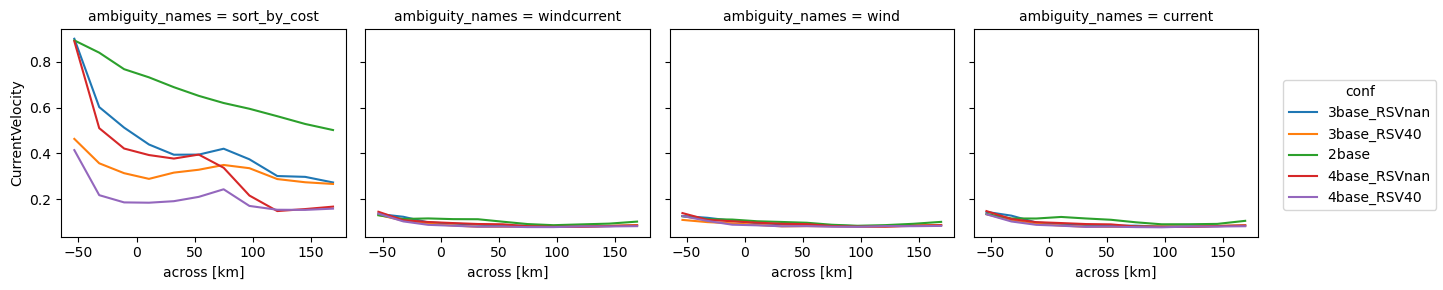

In [13]:
# RMSE MEAN Current Velocity
rmse.mean(dim='input_wdir').CurrentVelocity.plot(col='ambiguity_names', hue='conf', x='across')

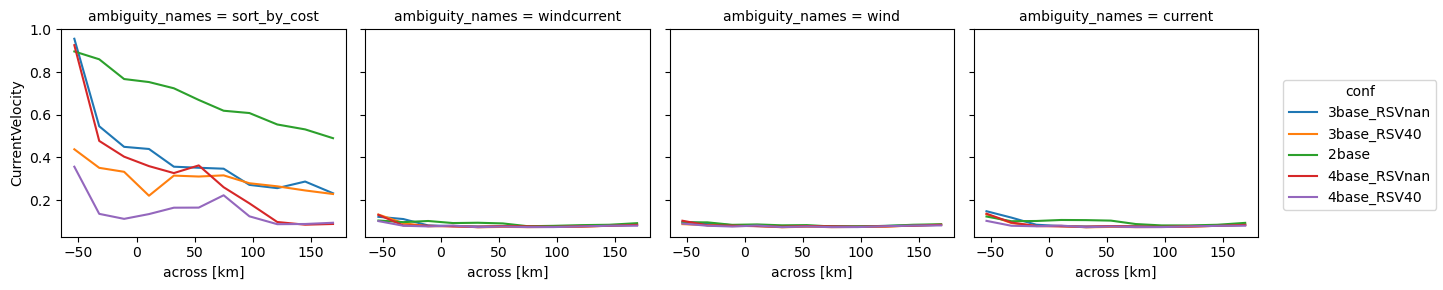

In [14]:
# RMSE MEDIAN Current Velocity
rmse.median(dim='input_wdir').CurrentVelocity.plot(col='ambiguity_names', hue='conf', x='across')

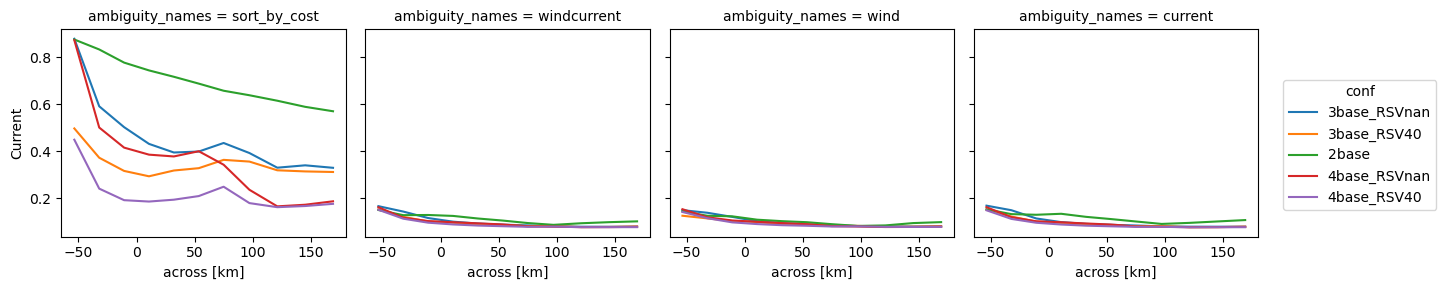

In [15]:
# Vector RMSE Mean CURRENT
vrmse.mean(dim='input_wdir').Current.plot(col='ambiguity_names', hue='conf', x='across')

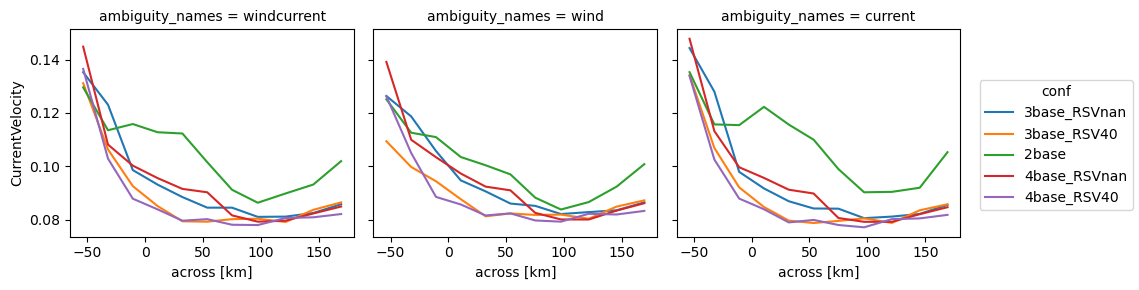

In [16]:
rmse.mean(dim='input_wdir').sel(ambiguity_names=['windcurrent','wind','current']).CurrentVelocity.plot(col='ambiguity_names',hue='conf', x='across')

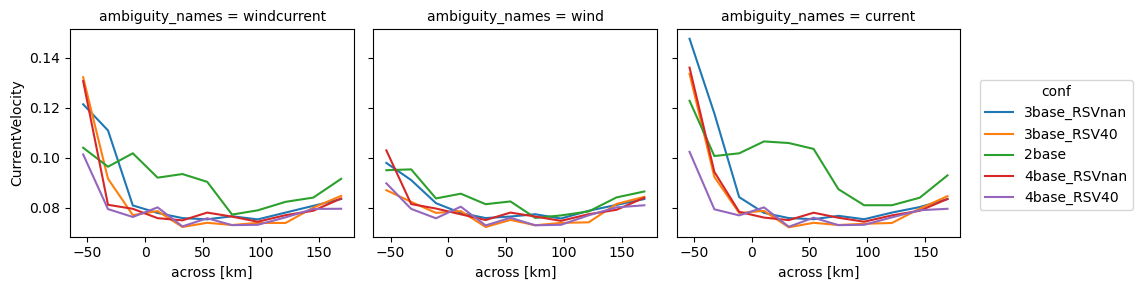

In [17]:
rmse.median(dim='input_wdir').sel(ambiguity_names=['windcurrent','wind','current']).CurrentVelocity.plot(col='ambiguity_names',hue='conf', x='across')

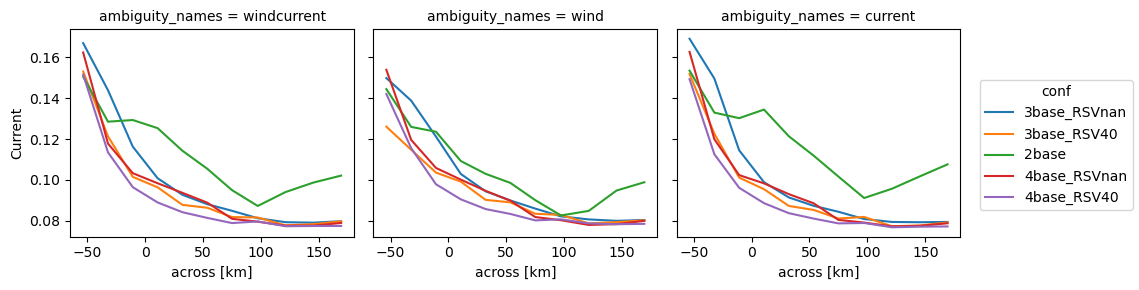

In [18]:
vrmse.mean(dim='input_wdir').sel(ambiguity_names=['windcurrent','wind','current']).Current.plot(col='ambiguity_names',hue='conf', x='across')

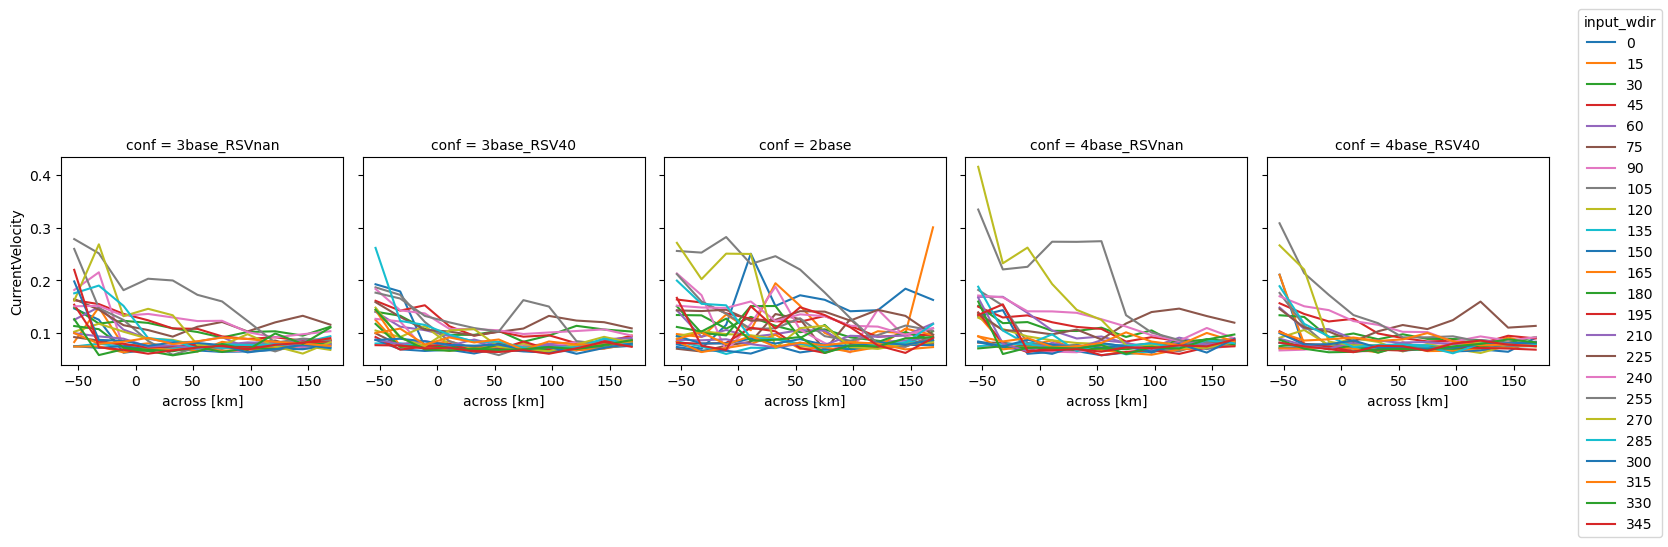

In [19]:
rmse.sel(ambiguity_names='current').CurrentVelocity.plot(col='conf',hue='input_wdir', x='across')

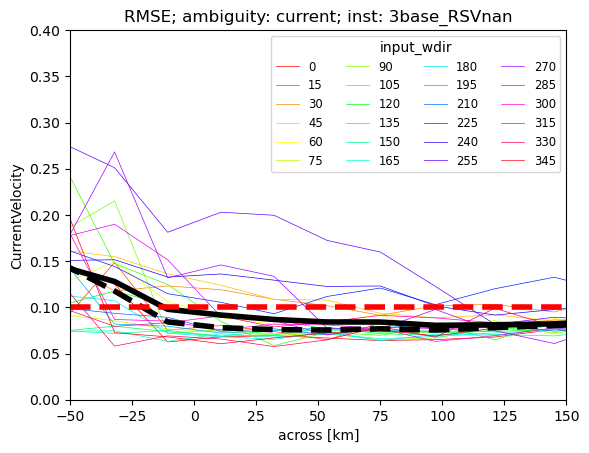

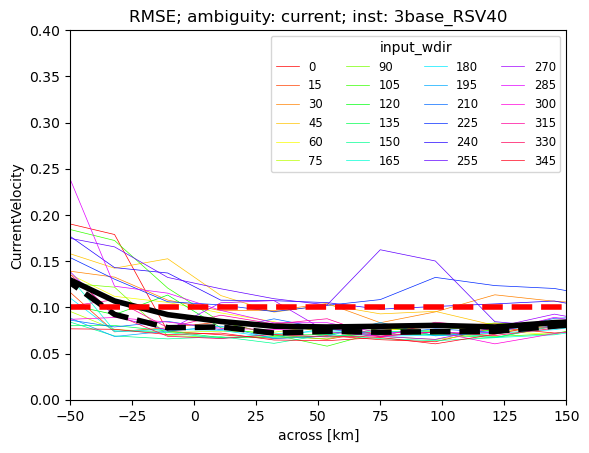

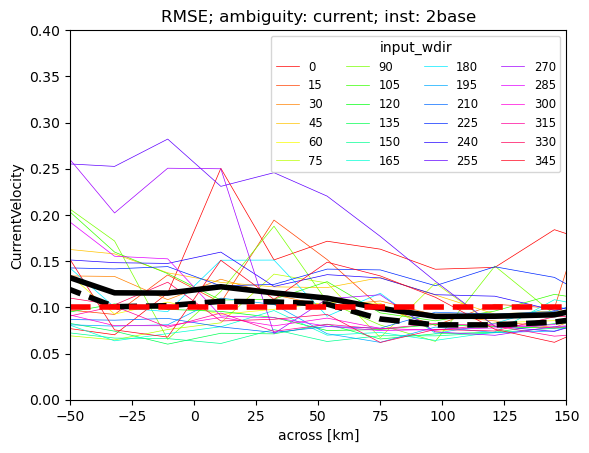

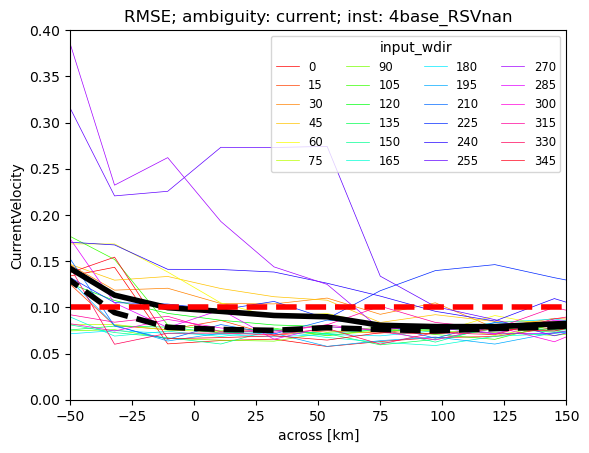

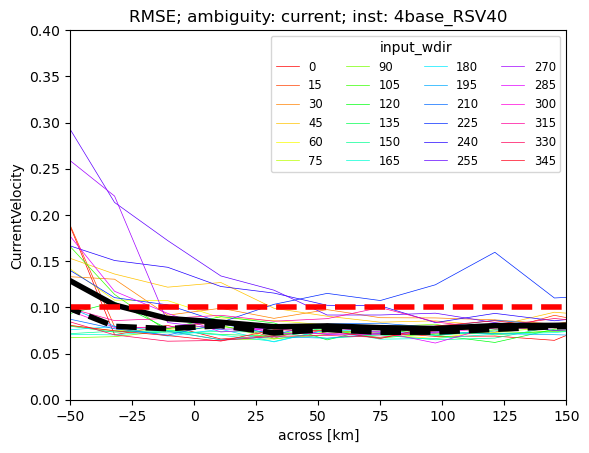

In [20]:
for cc, conf in enumerate(rmse.conf):
    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=rmse.CurrentVelocity\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    rmse.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    rmse.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,0.4])
    plt.xlim([-50,150])
    plt.title('RMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

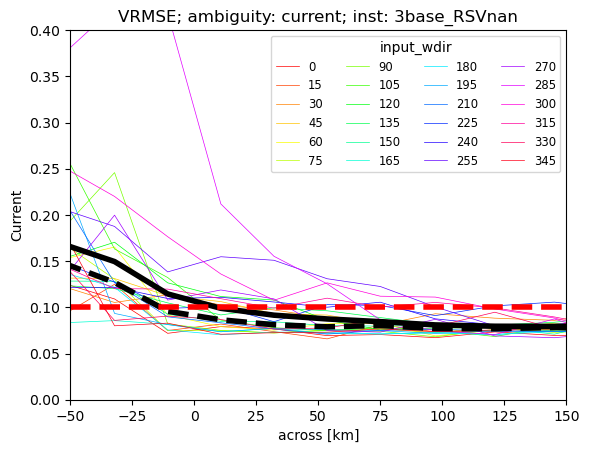

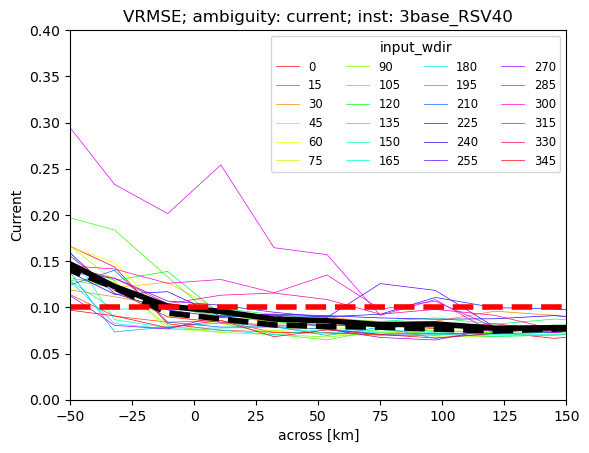

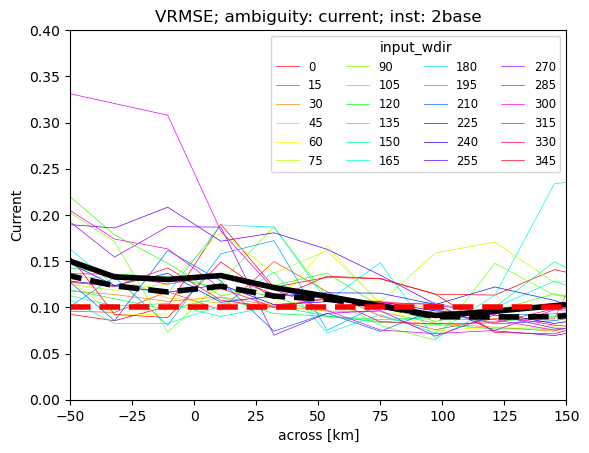

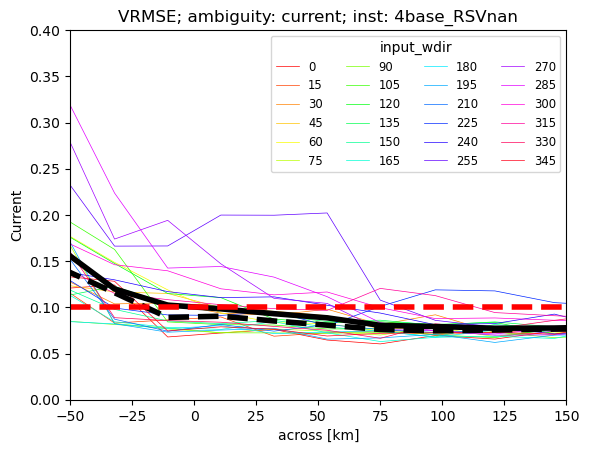

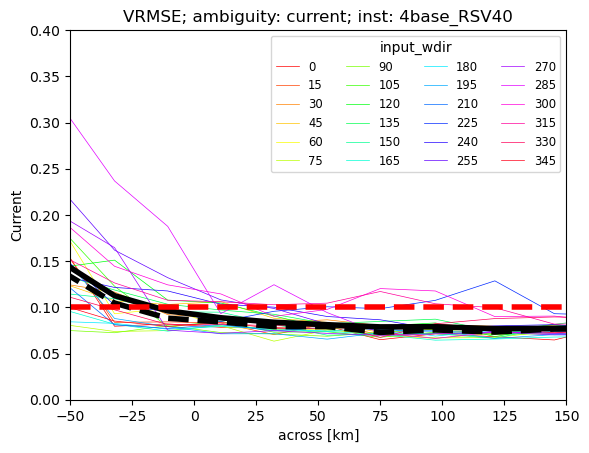

In [21]:
for cc, conf in enumerate(rmse.conf):

    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=vrmse.Current\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    vrmse.Current\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    vrmse.Current\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,0.4])
    plt.xlim([-50,150])
    plt.title('VRMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

In [22]:
np.where(vrmse.Current.sel(ambiguity_names='current').sel(across=slice(-60,150))>0.3)

(array([0, 0, 0, 1, 2, 2, 2, 3, 4], dtype=int64),
 array([19, 19, 19, 19, 19, 19, 19, 19, 19], dtype=int64),
 array([0, 1, 2, 0, 0, 1, 2, 0, 0], dtype=int64))

In [23]:
vrmse.Current.sel(ambiguity_names='current').isel(conf=0, input_wdir=[6,7,13,14,17,19,20])

<xarray.DataArray 'Current' (input_wdir: 7, across: 11)>
array([[0.18322763, 0.24579662, 0.08199919, 0.07503371, 0.07235478,
        0.07492766, 0.07410167, 0.06808333, 0.07622241, 0.075985  ,
        0.07243126],
       [0.27335754, 0.16314945, 0.13223649, 0.0861494 , 0.0779354 ,
        0.07481109, 0.07768704, 0.07566185, 0.06835058, 0.07995813,
        0.07473491],
       [0.24820756, 0.0933897 , 0.08128444, 0.07356505, 0.07713706,
        0.07578062, 0.07482909, 0.07176751, 0.07452196, 0.07389897,
        0.07694819],
       [0.21965969, 0.12661044, 0.08970255, 0.08326409, 0.07653256,
        0.07102616, 0.07503931, 0.07641496, 0.07416435, 0.07406872,
        0.07327409],
       [0.20665434, 0.1875371 , 0.13833196, 0.15474933, 0.15091686,
        0.13092736, 0.12254667, 0.10048389, 0.07987799, 0.07948819,
        0.07412436],
       [0.37227103, 0.4249198 , 0.41827504, 0.21188722, 0.15522202,
        0.12544029, 0.08641545, 0.07471597, 0.07051072, 0.08742919,
        0.06620885],
       [0.25276915, 0.21997846, 0.17641337, 0.13607396, 0.10764379,
        0.12647783, 0.11202751, 0.11108452, 0.09821057, 0.08844825,
        0.07251613]])
Coordinates:
  * across           (across) float64 -53.57 -32.14 -10.71 ... 121.2 145.2 169.2
    CentralFreq      float64 1.35e+10
  * input_wdir       (input_wdir) int32 90 105 195 210 255 285 300
    conf             <U12 '3base_RSVnan'
    ambiguity_names  <U12 'current'

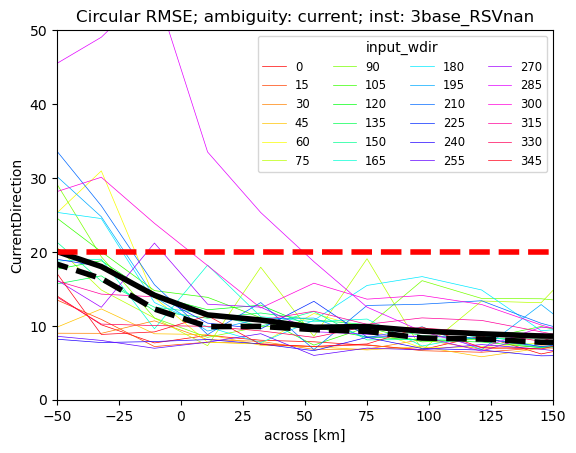

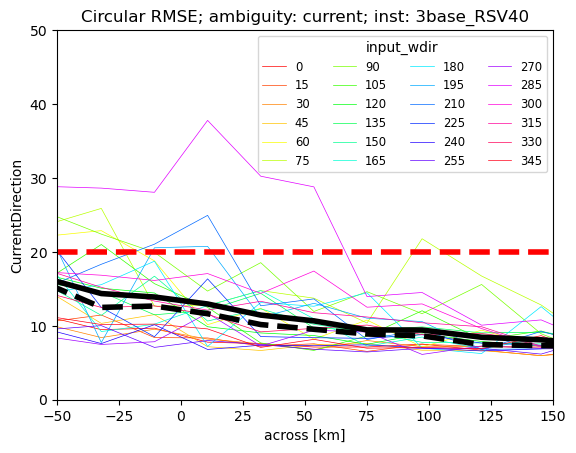

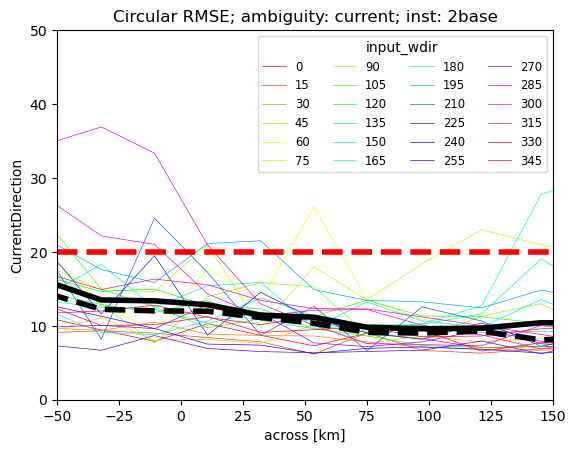

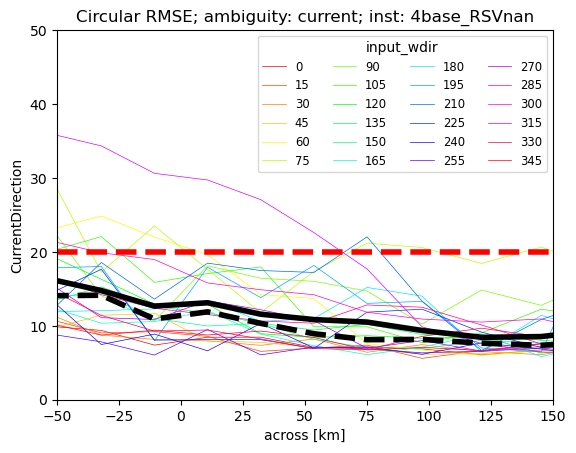

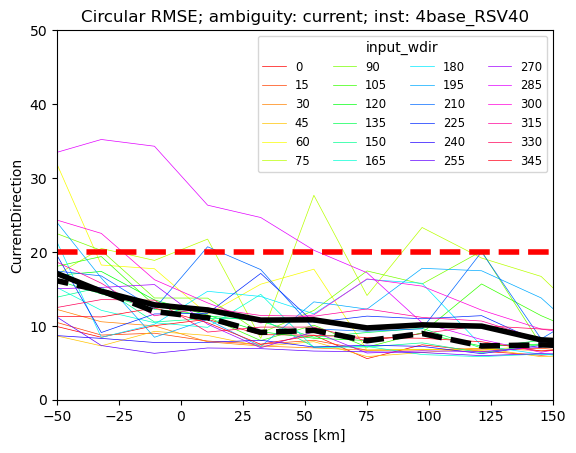

In [24]:
for cc, conf in enumerate(rmse.conf):

    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=crmse.CurrentDirection\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    crmse.CurrentDirection\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    crmse.CurrentDirection\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [20, 20], 'r--', lw=4)
    plt.ylim([0,50])
    plt.xlim([-50,150])
    plt.title('Circular RMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(crmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# Analysis for 3 sqt 29 

In [27]:
level2_tmp2 = [None] * len(config_3sq29)
truth_tmp2 = [None] * len(config_3sq29)
for cc, conf in enumerate(config_3sq29):
    for ii, inwdir in enumerate(input_wdir_list):
        filename = conf['instname'] + '_W005_{:03.0f}_C0.6_150_N4DS_M12'.format(inwdir)
        filename_l2 = 'level2_' + filename + '_' + conf['version'] + '.nc'
        filename_truth = 'truth_' + filename + '.nc'
        level2_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'level2s',conf['version'],filename_l2))
        level2_tmp[ii]['input_wdir'] = inwdir
        level2_tmp[ii] = level2_tmp[ii].drop_dims(['Antenna', 'fun_variables']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'truths',conf['nickname'] + '_' + conf['size'],filename_truth))
        truth_tmp[ii]['input_wdir'] = inwdir
        truth_tmp[ii] = truth_tmp[ii].drop_dims(['Antenna']) # need to drop Antenna to merge different conf
        truth_tmp[ii] = truth_tmp[ii].drop_vars(['WindSpeed','WindDirection'],errors='ignore')
    level2_tmp2[cc] = xr.concat(level2_tmp, dim='input_wdir')
    truth_tmp2[cc] = xr.concat(truth_tmp, dim='input_wdir')
level2_3sq29 = xr.concat(level2_tmp2, dim='conf') 
level2_3sq29['conf'] = [conf['nickname2'] for conf in config_3sq29]
truth_3sq29 = xr.concat(truth_tmp2, dim='conf') 
truth_3sq29['conf'] = [conf['nickname2'] for conf in config_3sq29]

for var in level2_3sq29.x_variables.data:
    level2_3sq29[var] = level2_3sq29.x.sel(x_variables=var)
    

ambiguity_list_3sq29 = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth_3sq29, 'method': 'windcurrent'},
    {'name': 'closest_truth', 'truth': truth_3sq29, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth', 'truth': truth_3sq29, 'method': 'current'},
]
sol_list_3sq29 = [None] * len(ambiguity_list_3sq29)
ambiguity_names_3sq29 = [None] * len(ambiguity_list_3sq29)
for ii in range(len(sol_list)):
    sol_list_3sq29[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2_3sq29, ambiguity_list_3sq29[ii])
    ambiguity_names_3sq29[ii] = ambiguity_list_3sq29[ii]['method']
    sol_list_3sq29[ii] = sol_list_3sq29[ii].drop_vars('x_reduce', errors='ignore')

sol_3sq29 = xr.concat(sol_list_3sq29, dim='ambiguity_names')
sol_3sq29.coords['ambiguity_names'] = ambiguity_names_3sq29

level2b_3sq29 = seastar.retrieval.level2.sol2level2(sol_3sq29)

err_3sq29 = level2b_3sq29 - truth_3sq29
err_3sq29['flag'] = level2b_3sq29.cost > 4
err_3sq29 = err_3sq29.set_coords('flag')
# Std RMSE
rmse_3sq29 = np.sqrt((err_3sq29.where(~err_3sq29.flag)**2).mean(dim='along'))
# Vector RMSE
vrmse_3sq29 = xr.Dataset()
for field in ['Current','OceanSurfaceWind','EarthRelativeWind']:
    vrmse_3sq29[field] = np.sqrt((err_3sq29[field + 'U'].where(~err_3sq29.flag)**2 + err_3sq29[field + 'V'].where(~err_3sq29.flag)**2)\
                           .mean(dim='along'))\
                        /np.sqrt(2)
# rmse for the circular variables
cmean_tmp_3sq29 = np.mod(err_3sq29,360).reduce(circmean, dim='along', low=0, high=360)
cmean_3sq29 = (np.mod((cmean_tmp_3sq29-180),360)-180) # centre around 0
cstd_3sq29 = np.mod(err_3sq29,360).reduce(circstd, dim='along', low=0, high=360)
crmse_3sq29 = np.sqrt(cmean_3sq29**2 + cstd_3sq29**2)

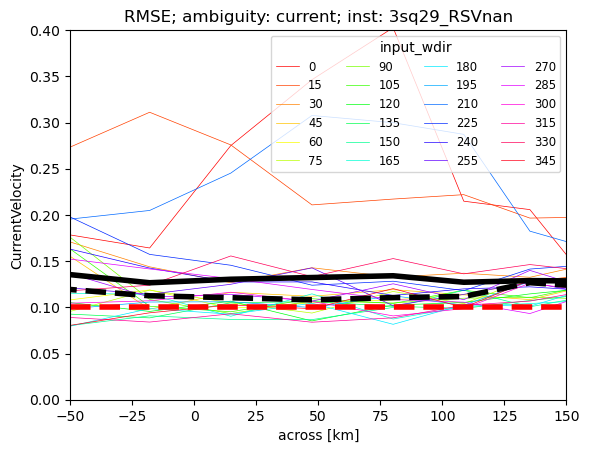

In [28]:
for cc, conf in enumerate(rmse_3sq29.conf):
    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=rmse_3sq29.CurrentVelocity\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    rmse_3sq29.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    rmse_3sq29.CurrentVelocity\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,0.4])
    plt.xlim([-50,150])
    plt.title('RMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

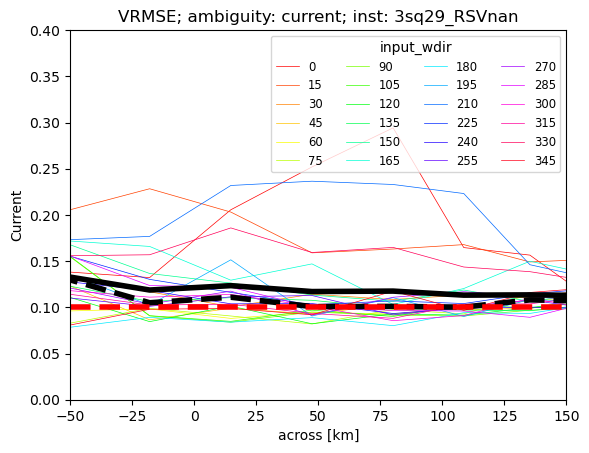

In [29]:
for cc, conf in enumerate(vrmse_3sq29.conf):
    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=vrmse_3sq29.Current\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    vrmse_3sq29.Current\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    vrmse_3sq29.Current\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,0.4])
    plt.xlim([-50,150])
    plt.title('VRMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

In [30]:
np.where(vrmse_3sq29.Current.sel(ambiguity_names='current').sel(across=slice(0,120))>0.15)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([ 0,  0,  0,  0,  1,  1,  1,  1, 13, 14, 14, 14, 14, 22, 22, 22],
       dtype=int64),
 array([0, 1, 2, 3, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 1, 2], dtype=int64))

In [31]:
vrmse_3sq29.Current.sel(across=slice(-60,150)).sel(ambiguity_names='current').isel(conf=0, input_wdir=[0,1,13,14,22])

<xarray.DataArray 'Current' (input_wdir: 5, across: 7)>
array([[0.13825182, 0.13219702, 0.20555086, 0.25193652, 0.29420678,
        0.16465586, 0.15650381],
       [0.20512243, 0.22832526, 0.20309577, 0.15895046, 0.16311602,
        0.1678706 , 0.1491283 ],
       [0.13540113, 0.10250154, 0.15141938, 0.09060451, 0.11043843,
        0.09006503, 0.10834896],
       [0.17316449, 0.17675733, 0.23185667, 0.23648557, 0.23292953,
        0.22315589, 0.14611613],
       [0.15580205, 0.15688862, 0.18593618, 0.15933639, 0.16484954,
        0.14362632, 0.13857821]])
Coordinates:
  * across           (across) float64 -50.73 -18.0 14.73 47.45 80.18 108.7 135.3
    CentralFreq      float64 1.35e+10
  * input_wdir       (input_wdir) int32 0 15 195 210 330
    conf             <U12 '3sq29_RSVnan'
    ambiguity_names  <U12 'current'

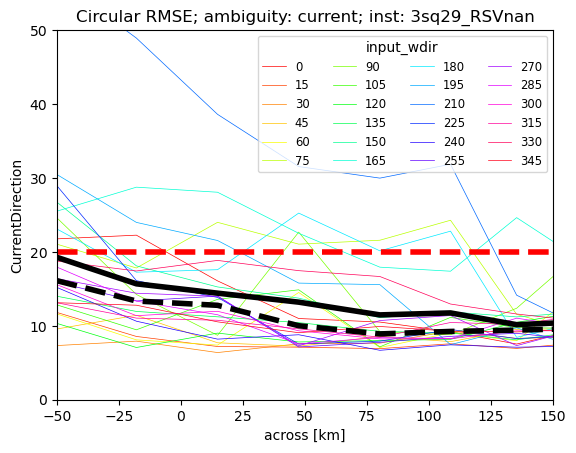

In [32]:
for cc, conf in enumerate(crmse_3sq29.conf):
    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=crmse_3sq29.CurrentDirection\
            .sel(ambiguity_names='current')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    crmse_3sq29.CurrentDirection\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    crmse_3sq29.CurrentDirection\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    plt.plot([-50, 160], [20, 20], 'r--', lw=4)
    plt.ylim([0,50])
    plt.xlim([-50,150])
    plt.title('Circular RMSE; ambiguity: current' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

# Analysis all config for ambiguity 'current'

Text(0.5, 1.0, 'RMSE Current Velocity mean in wdir; ambiguity: current')

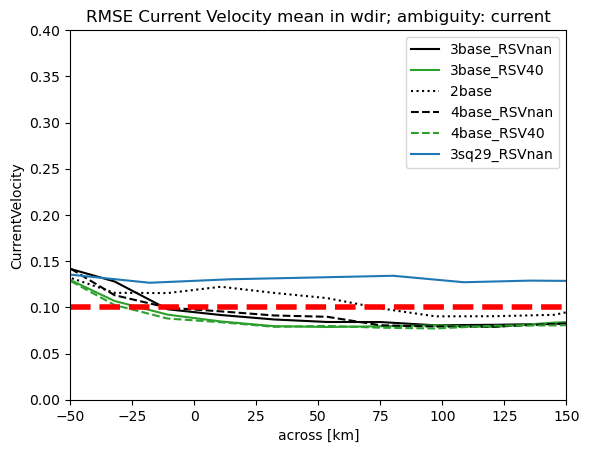

In [33]:
fig, ax = plt.subplots()
for cc, conf in enumerate(rmse.conf):
    rmse.mean(dim='input_wdir').sel(ambiguity_names=['current']).CurrentVelocity\
        .sel(conf=conf.values)\
        .plot(x='across', color=config[cc]['color'], ls=config[cc]['ls'], label=conf.values[()])
rmse_3sq29.mean(dim='input_wdir').sel(ambiguity_names=['current']).CurrentVelocity\
    .plot(x='across', color=config_3sq29[0]['color'], ls=config_3sq29[0]['ls'], label=rmse_3sq29.conf.values[0])
plt.legend()
plt.plot([-50, 160], [.1, .1], 'r--', lw=4)
plt.ylim([0,.4])
plt.xlim([-50,150])
plt.title('RMSE Current Velocity mean in wdir; ambiguity: current')

Text(0.5, 1.0, 'VRMSE mean in wdir; ambiguity: current')

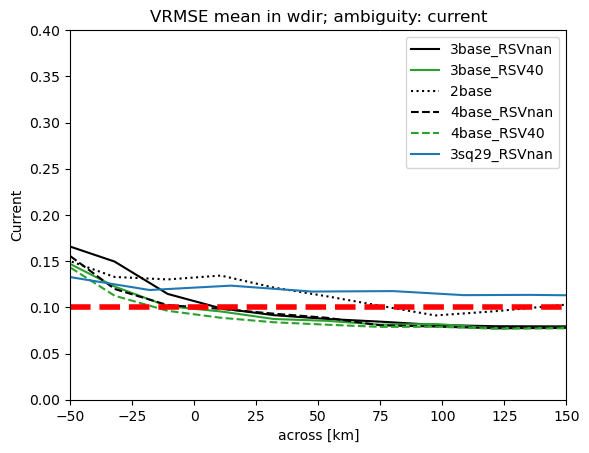

In [34]:
fig, ax = plt.subplots()
for cc, conf in enumerate(rmse.conf):
    vrmse.mean(dim='input_wdir').sel(ambiguity_names=['current']).Current\
        .sel(conf=conf.values)\
        .plot(x='across', color=config[cc]['color'], ls=config[cc]['ls'], label=conf.values[()])
vrmse_3sq29.mean(dim='input_wdir').sel(ambiguity_names=['current']).Current\
    .plot(x='across', color=config_3sq29[0]['color'], ls=config_3sq29[0]['ls'], label=rmse_3sq29.conf.values[0])
plt.legend()
plt.plot([-50, 160], [.1, .1], 'r--', lw=4)
plt.ylim([0,.4])
plt.xlim([-50,150])
plt.title('VRMSE mean in wdir; ambiguity: current')

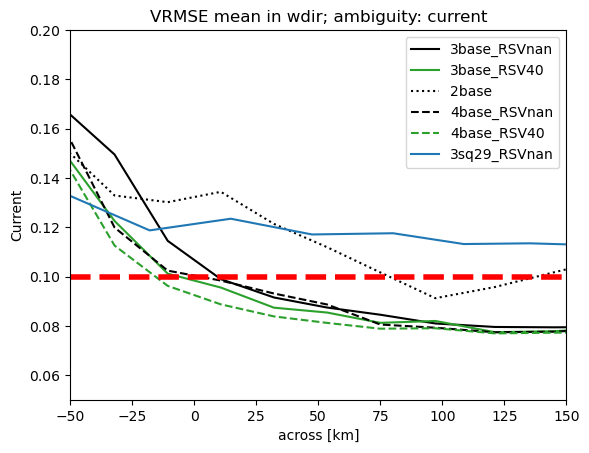

In [50]:
# Zoom
fig, ax = plt.subplots()
for cc, conf in enumerate(rmse.conf):
    vrmse.mean(dim='input_wdir').sel(ambiguity_names=['current']).Current\
        .sel(conf=conf.values)\
        .plot(x='across', color=config[cc]['color'], ls=config[cc]['ls'], label=conf.values[()])
vrmse_3sq29.mean(dim='input_wdir').sel(ambiguity_names=['current']).Current\
    .plot(x='across', color=config_3sq29[0]['color'], ls=config_3sq29[0]['ls'], label=rmse_3sq29.conf.values[0])
plt.legend()
plt.plot([-50, 160], [.1, .1], 'r--', lw=4)
plt.ylim([0.05,.2])
plt.xlim([-50,150])
plt.title('VRMSE mean in wdir; ambiguity: current')
plt.savefig("VRMSE_mean_all_conf_zoom.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 1.0, 'VRMSE median in wdir; ambiguity: current')

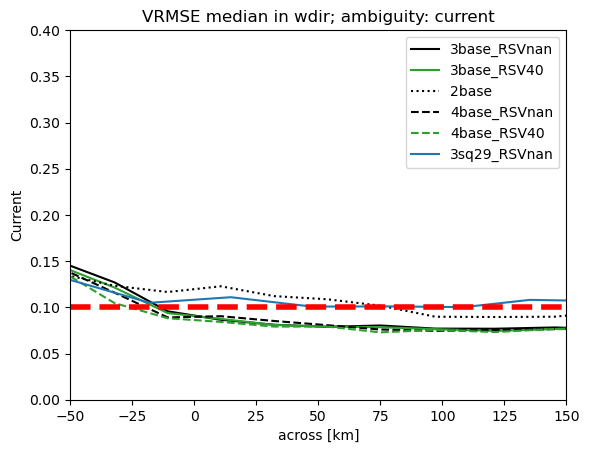

In [36]:
fig, ax = plt.subplots()
for cc, conf in enumerate(rmse.conf):
    vrmse.median(dim='input_wdir').sel(ambiguity_names=['current']).Current\
        .sel(conf=conf.values)\
        .plot(x='across', color=config[cc]['color'], ls=config[cc]['ls'], label=conf.values[()])
vrmse_3sq29.median(dim='input_wdir').sel(ambiguity_names=['current']).Current\
    .plot(x='across', color=config_3sq29[0]['color'], ls=config_3sq29[0]['ls'], label=rmse_3sq29.conf.values[0])
plt.legend()
plt.plot([-50, 160], [.1, .1], 'r--', lw=4)
plt.ylim([0,.4])
plt.xlim([-50,150])
plt.title('VRMSE median in wdir; ambiguity: current')

Text(0.5, 1.0, 'VRMSE median in wdir; ambiguity: current')

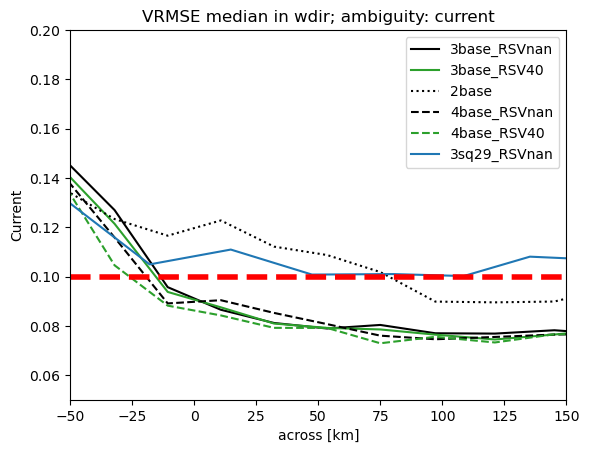

In [37]:
# Zoom
fig, ax = plt.subplots()
for cc, conf in enumerate(rmse.conf):
    vrmse.median(dim='input_wdir').sel(ambiguity_names=['current']).Current\
        .sel(conf=conf.values)\
        .plot(x='across', color=config[cc]['color'], ls=config[cc]['ls'], label=conf.values[()])
vrmse_3sq29.median(dim='input_wdir').sel(ambiguity_names=['current']).Current\
    .plot(x='across', color=config_3sq29[0]['color'], ls=config_3sq29[0]['ls'], label=rmse_3sq29.conf.values[0])
plt.legend()
plt.plot([-50, 160], [.1, .1], 'r--', lw=4)
plt.ylim([0.05,.2])
plt.xlim([-50,150])
plt.title('VRMSE median in wdir; ambiguity: current')

# Analysis using ambiguity "sort by cost" using VRMSE

In [38]:
vrmse

<xarray.Dataset>
Dimensions:            (across: 11, input_wdir: 24, conf: 5, ambiguity_names: 4)
Coordinates:
  * across             (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
    CentralFreq        float64 1.35e+10
  * input_wdir         (input_wdir) int32 0 15 30 45 60 ... 285 300 315 330 345
  * conf               (conf) <U12 '3base_RSVnan' ... '4base_RSV40'
  * ambiguity_names    (ambiguity_names) <U12 'sort_by_cost' ... 'current'
Data variables:
    Current            (ambiguity_names, conf, input_wdir, across) float64 0....
    OceanSurfaceWind   (ambiguity_names, conf, input_wdir, across) float64 3....
    EarthRelativeWind  (ambiguity_names, conf, input_wdir, across) float64 3....

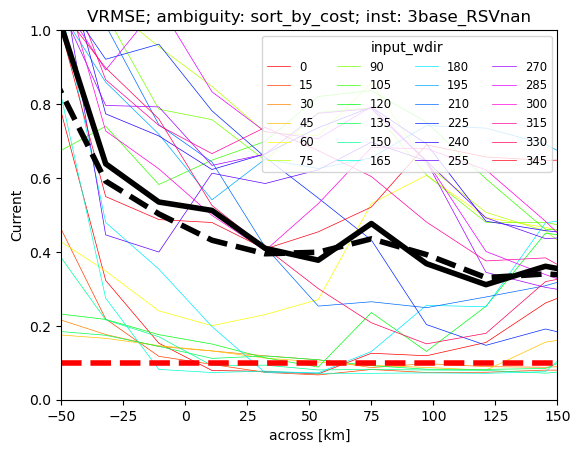

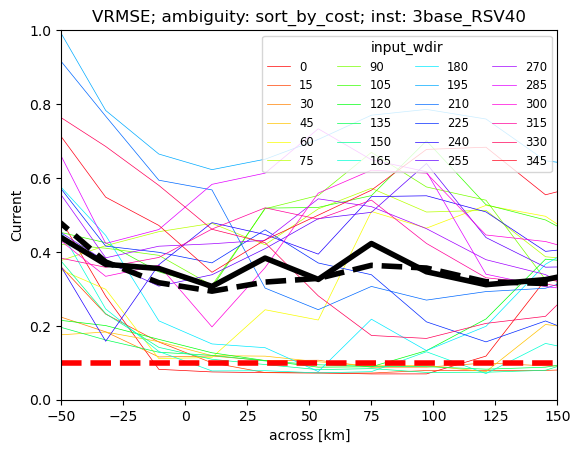

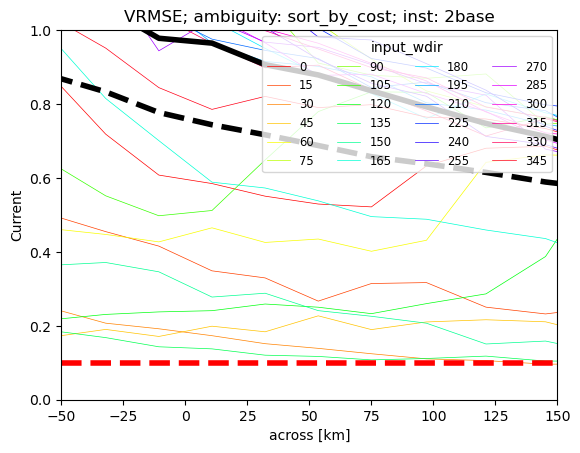

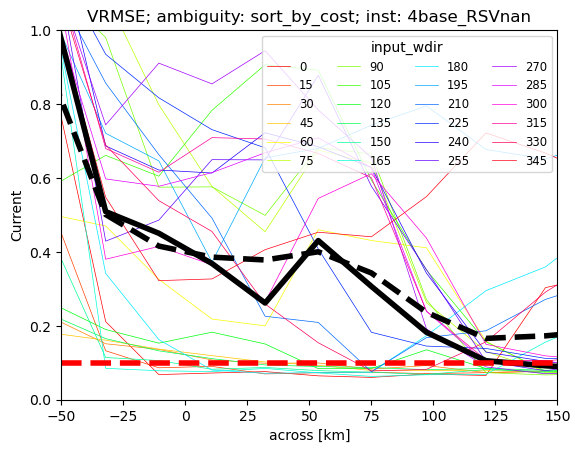

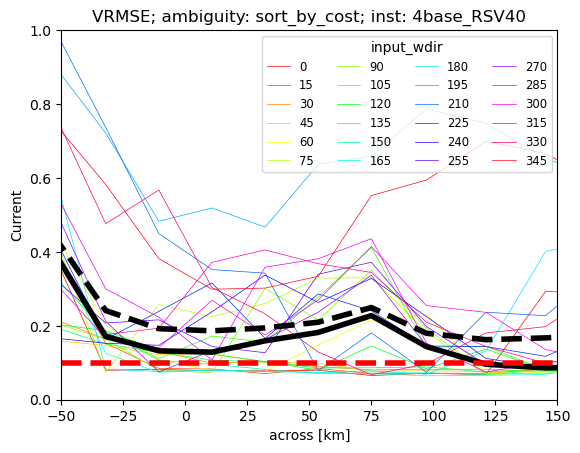

In [39]:
for cc, conf in enumerate(rmse.conf):

    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=vrmse.Current\
            .sel(ambiguity_names='sort_by_cost')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    vrmse.Current\
        .sel(ambiguity_names='sort_by_cost')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    vrmse.Current\
        .sel(ambiguity_names='sort_by_cost')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,1])
    plt.xlim([-50,150])
    plt.title('VRMSE; ambiguity: sort_by_cost' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

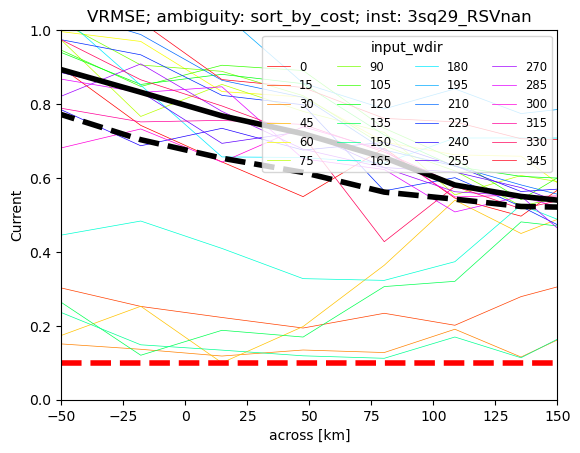

In [40]:
for cc, conf in enumerate(vrmse_3sq29.conf):
    fig, ax = plt.subplots()
    cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
    ax.set_prop_cycle("color", cmap)
    g=vrmse_3sq29.Current\
            .sel(ambiguity_names='sort_by_cost')\
            .sel(conf=conf.values)\
            .plot(x='across', hue='input_wdir',
                 linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
    vrmse_3sq29.Current\
        .sel(ambiguity_names='sort_by_cost')\
        .sel(conf=conf.values)\
        .mean(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
    vrmse_3sq29.Current\
        .sel(ambiguity_names='sort_by_cost')\
        .sel(conf=conf.values)\
        .median(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
    plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
    plt.ylim([0,1])
    plt.xlim([-50,150])
    plt.title('VRMSE; ambiguity: sort_by_cost' + '; inst: ' + conf.values[()])
    ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

In [41]:
# summary figure for 3base_RSVnan SeaSTAR baseline for the paper

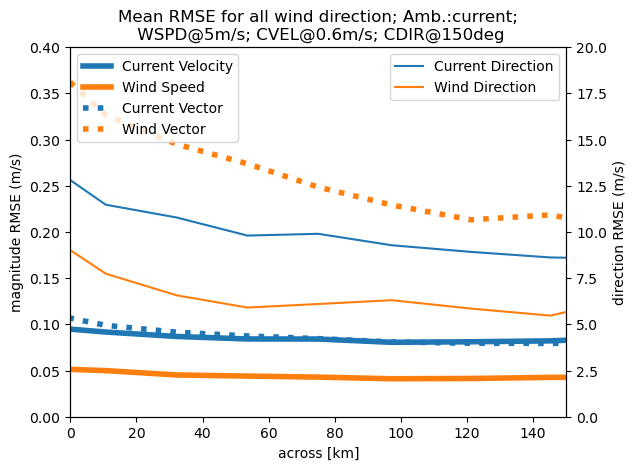

In [49]:
vel_threshold = 0.4
dir_threshold = 20

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlim([0, 150])
ax1.set_ylim([0, vel_threshold])
ax2.set_ylim([0, dir_threshold])

# Velocity
# ax1.plot([-50, 160], [vel_threshold, vel_threshold], 'r--', lw=4)
rmse.sel(ambiguity_names='current', conf='3base_RSVnan').CurrentVelocity.mean(dim='input_wdir').plot(ax=ax1, color='C0', lw=4, label='Current Velocity')
rmse.sel(ambiguity_names='current', conf='3base_RSVnan').OceanSurfaceWindSpeed.mean(dim='input_wdir').plot(ax=ax1, color='C1', lw=4, label='Wind Speed')
vrmse.sel(ambiguity_names='current', conf='3base_RSVnan').Current.mean(dim='input_wdir').plot(ax=ax1, color='C0', lw=4, ls=':', label='Current Vector')
vrmse.sel(ambiguity_names='current', conf='3base_RSVnan').OceanSurfaceWind.mean(dim='input_wdir').plot(ax=ax1, color='C1', lw=4, ls=':', label='Wind Vector')
# m_rmse.sel(ambiguity_names='current').EarthRelativeWindSpeed.plot(ax=ax1, color='C2', lw=4, label='ERWSpd')
ax1.set_ylabel('magnitude RMSE (m/s)')

# Direction
# ax2.plot([-50, 160], [dir_threshold, dir_threshold], 'r--', lw=4)
crmse.sel(ambiguity_names='current', conf='3base_RSVnan').CurrentDirection.mean(dim='input_wdir').plot(ax=ax2, color='C0', label='Current Direction')
crmse.sel(ambiguity_names='current', conf='3base_RSVnan').OceanSurfaceWindDirection.mean(dim='input_wdir').plot(ax=ax2, color='C1', label='Wind Direction')
# m_crmse.sel(ambiguity_names='current').EarthRelativeWindDirection.plot(ax=ax2, color='C2', label='ERWDir')
ax2.set_ylabel('direction RMSE (m/s)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_title(f'Mean RMSE for all wind direction; Amb.:current;\n WSPD@5m/s; CVEL@0.6m/s; CDIR@150deg')
ax2.set_title('')
plt.savefig("RMSE_mean_magnitude_vector_direction_3base_RSVnan.pdf", format="pdf", bbox_inches="tight")

In [45]:
rmse.conf.sel(conf='3base_RSVnan')

<xarray.DataArray 'conf' ()>
array('3base_RSVnan', dtype='<U12')
Coordinates:
    CentralFreq  float64 1.35e+10
    conf         <U12 '3base_RSVnan'

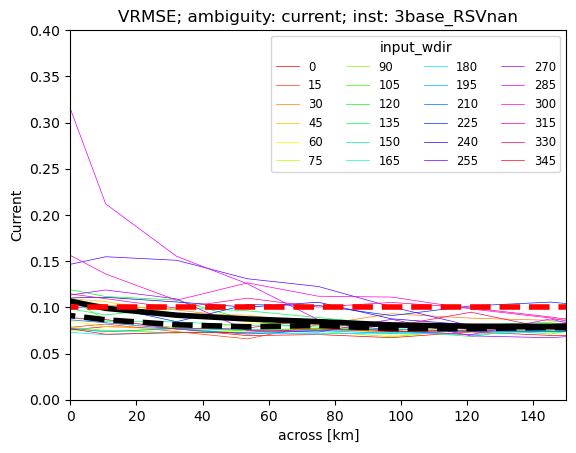

In [48]:
conf = rmse.conf.sel(conf='3base_RSVnan')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=vrmse.Current\
        .sel(ambiguity_names='current')\
        .sel(conf=conf.values)\
        .plot(x='across', hue='input_wdir',
             linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
vrmse.Current\
    .sel(ambiguity_names='current')\
    .sel(conf=conf.values)\
    .mean(dim='input_wdir').plot(ls='-', color='k', linewidth=4)
vrmse.Current\
    .sel(ambiguity_names='current')\
    .sel(conf=conf.values)\
    .median(dim='input_wdir').plot(ls='--', color='k', linewidth=4)
plt.plot([-60, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.xlim([0,150])
plt.title('VRMSE; ambiguity: current' + '; inst: ' + conf.values[()])
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')
plt.savefig("VRMSE_3base_RSVnan.pdf", format="pdf", bbox_inches="tight")